# # Code Generator
- jupyter에서 작업한 내용을 .py 파일로 쉽게 내보내기 위해 magic command 이용
- 첫 줄의 %%writefile을 주석처리 하지 않으면 해당 셀 내용을 `name.py` 파일로 export
- 첫 줄의 %%writefile을 주석처리하면 jupyter에서 실행됨
- 코딩을 .py파일이 아닌 jupyter에서 작업

## flag.py

In [ ]:
from document import Document
from analysis import Analysis
from word_vector import WordVector
from classifier import Classifier
import pandas as pd
import numpy as np

def train(epochs=10,
          batch_size=100,
          validation_split=0.1,
          verbose=0,
          checkpoint_path='./model/checkpoints'):
    """
    classifier 학습
    
    - input
    : epochs / int / 학습 횟수
    : batch_size / int / 배치 사이즈
    : validation_split / float / validation data ratio
    : checkpoint_path / str / 학습 중간 결과물 저장 경로
    
    - export
    : ./model/classifier.json (graph)
    : ./model/classifier.h5 (weights)
    """
    
    # load data
    data = getTrainData()
    
    # train
    model = cf.train(data,
                 checkpoint_path=checkpoint_path,
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_split=validation_split,
                 verbose=verbose)
    cf.showHistory()

def getTrainData():
    """
    라벨링 된 데이터를 임베딩하여 반환
    
    - return
    : DataFrame
    """
    
    # 라벨링 된 데이터만 가져오기
    data = doc.getDocs(True) 
    
    # vectorization
    data['vector'] = data.text.apply(lambda x: wv.vectorization(wv_model, x))
    return data

def predict(text, criterion=0.5):
    """
    개발관련 문서여부 반환
    
    - input
    : text / str / 확인하려는 문서 내용 (영어 또는 한글이 포함되어있어야함)
    : criterion / float / 개발관련 문서 판단 기준
    
    - return
    : boolean / 개발문서 여부
    : float / 1에 가까울수록 개발관련 문서
    """
    data = doc.preprocessing(pd.DataFrame([{
        'title': text,
        'description': '',
        'tags': []
    }]))
    data = data.text.apply(lambda x: wv.vectorization(wv_model, x)).tolist()

    if len(data) == 0:
        print('text is not valid')
        return
    data = np.array(data)
    confidence = round(model.predict(data)[0][1], 3)
    is_dev_doc = confidence > criterion
    return is_dev_doc, confidence

def getDataAnalysis():
    """
    가지고있는 전체 데이터 분석
    : label 별 수량
    : 문장 길이 histogram
    : WordCloud 
    """
    # 학습 데이터 분석
    Analysis(doc.getDocs(labeled_only=False))
    
def getSimilarWords(text, topn=5):
    """
    단어 임베딩 모델을 이용하여 주어진 단어와 유사도가 높은 단어를 반환
    
    - input
    : text / str / 유사도를 구하려는 단어
    : topn / int / 조회하려는 단어의 개수(유사도가 높은 순서로 자름)
    
    - return
    : list / [(string : word, float : similarity)]
    """
    # 유사 단어 조회
    return wv.getSimilarWords(wv_model, text, topn)

In [65]:
# %%writefile ./flags.py
import os, re
from absl import flags

FLAGS = flags.FLAGS

def create_flags():
    f = flags

    # flags
    f.DEFINE_enum('wv_model', 'devblog', ['wiki', 'devblog'], 'word embedding model')
    f.DEFINE_string('predict', None, "sentence you want to predict. ex) 'hello world'")
    
    # validation
    f.register_validator('predict',
                         lambda x: x != None,
                         message="write the sentence you want to predict. ex) 'how to use python'")

    # require
    f.mark_flag_as_required('predict')

Overwriting ./flags.py


## main.py

In [66]:
%%writefile ./main.py
from absl import app
from flags import create_flags
from document import Document
from analysis import Analysis
from word_vector import WordVector
from classifier import Classifier
import pandas as pd
import numpy as np

doc = Document()
wv = WordVector()
cf = Classifier()
wv_model = wv.getWikiModel()
model = cf.loadModel()

def train(epochs=10,
          batch_size=100,
          validation_split=0.1,
          verbose=0,
          checkpoint_path='./model/checkpoints'):
    """
    classifier 학습
    
    - input
    : epochs / int / 학습 횟수
    : batch_size / int / 배치 사이즈
    : validation_split / float / validation data ratio
    : checkpoint_path / str / 학습 중간 결과물 저장 경로
    
    - export
    : ./model/classifier.json (graph)
    : ./model/classifier.h5 (weights)
    """
    
    # load data
    data = getTrainData()
    
    # train
    model = cf.train(data,
                 checkpoint_path=checkpoint_path,
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_split=validation_split,
                 verbose=verbose)
    cf.showHistory()

def getTrainData():
    """
    라벨링 된 데이터를 임베딩하여 반환
    
    - return
    : DataFrame
    """
    
    # 라벨링 된 데이터만 가져오기
    data = doc.getDocs(True) 
    
    # vectorization
    data['vector'] = data.text.apply(lambda x: wv.vectorization(wv_model, x))
    return data

def predict(text, criterion=0.5):
    """
    개발관련 문서여부 반환
    
    - input
    : text / str / 확인하려는 문서 내용 (영어 또는 한글이 포함되어있어야함)
    : criterion / float / 개발관련 문서 판단 기준
    
    - return
    : boolean / 개발문서 여부
    : float / 1에 가까울수록 개발관련 문서
    """
    data = doc.preprocessing(pd.DataFrame([{
        'title': text,
        'description': '',
        'tags': []
    }]))
    data = data.text.apply(lambda x: wv.vectorization(wv_model, x)).tolist()

    if len(data) == 0:
        print('text is not valid')
        return
    data = np.array(data)
    confidence = round(model.predict(data)[0][1], 3)
    is_dev_doc = confidence > criterion
    return is_dev_doc, confidence

def getDataAnalysis():
    """
    가지고있는 전체 데이터 분석
    : label 별 수량
    : 문장 길이 histogram
    : WordCloud 
    """
    # 학습 데이터 분석
    Analysis(doc.getDocs(labeled_only=False))
    
def getSimilarWords(text, topn=5):
    """
    단어 임베딩 모델을 이용하여 주어진 단어와 유사도가 높은 단어를 반환
    
    - input
    : text / str / 유사도를 구하려는 단어
    : topn / int / 조회하려는 단어의 개수(유사도가 높은 순서로 자름)
    
    - return
    : list / [(string : word, float : similarity)]
    """
    # 유사 단어 조회
    return wv.getSimilarWords(wv_model, text, topn)

def main(_):
    doc = Document()
    wv = WordVector()
    cf = Classifier()
    
    


if __name__ == '__main__':
    create_flags()
    app.run(main)

Overwriting ./main.py


## util.py

In [67]:
# %%writefile ./util.py
import re
import urllib.request
import numpy as np
from tqdm import tqdm

def downloadByURL(url, output_path):
    """
    HTTP 파일 다운로드
    
    - input
    : url / str / 다운로드 받으려는 파일의 url
    : output_path / str / 파일 저장 경로
    """
    class DownloadProgressBar(tqdm):
        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None:
                self.total = tsize
            self.update(b * bsize - self.n)
        
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def han2Jamo(str):
    INITIALS = list("ㄱㄲㄴㄷㄸㄹㅁㅂㅃㅅㅆㅇㅈㅉㅊㅋㅌㅍㅎ")
    MEDIALS = list("ㅏㅐㅑㅒㅓㅔㅕㅖㅗㅘㅙㅚㅛㅜㅝㅞㅟㅠㅡㅢㅣ")
    FINALS = list("_ㄱㄲㄳㄴㄵㄶㄷㄹㄺㄻㄼㄽㄾㄿㅀㅁㅂㅄㅅㅆㅇㅈㅊㅋㅌㅍㅎ")
    SPACE_TOKEN = " "
    LABELS = sorted({SPACE_TOKEN}.union(INITIALS).union(MEDIALS).union(FINALS))

    def check_hangle(char):
        return 0xAC00 <= ord(char) <= 0xD7A3

    def jamo_split(char):
        assert check_hangle(char)
        diff = ord(char) - 0xAC00
        _m = diff % 28
        _d = (diff - _m) // 28
        return (INITIALS[_d // 21], MEDIALS[_d % 21], FINALS[_m])
    
    result = ""
    for char in re.sub("\\s+", SPACE_TOKEN, str.strip()):
        if char == SPACE_TOKEN:
            result += SPACE_TOKEN
        elif check_hangle(char):
            result += "".join(jamo_split(char))
        else:
            result += char
    return result

Overwriting ./util.py


## analysis.py

In [68]:
# %%writefile ./analysis.py
import os
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

class Analysis():
     
    def __init__(self, data):
        """
        데이터의 수량, 길이, WordCloud 분석
        
        - input
        : data / DataFrame / documents.csv 데이터
        """
        self.countAnalysis(data)
        print()
        self.textAnalysis(data)
        print()
        self.showWordCloud(data.text)
        
    def countAnalysis(self, data):
        """
        데이터 수량 조사
        
        - input
        : data / DataFrame / documents.csv 데이터
        """
        
        labeled_data = data.loc[data.label != -1]
        total_count = len(data) # 전체 데이터 수
        labeled_count = len(labeled_data) # 라벨링 된 데이터 수

        print('> 데이터 수량 조사')
        print(f'전체 데이터 수: {total_count}개')
        print(f'라벨링된 데이터 수: {labeled_count}개')
        for label, count in data.label.value_counts().iteritems():
            print(f'class {label} : {count}개')
    
    def textAnalysis(self, data):
        """
        text 길이 분석
        
        - input
        : data / DataFrame / documents.csv 데이터
        """
        text_len = data.text.apply(len)
        plt.figure(figsize=(12, 5))
        plt.hist(text_len, bins=200, alpha=0.5, color= 'r', label='length of text')
        plt.legend(fontsize='x-large')
        plt.yscale('log', nonposy='clip')
        plt.title('Log-Histogram of length of text')
        plt.xlabel('Length of text')
        plt.ylabel('Number of text')

        print('> 문장 길이 분석')
        print('문장 길이 최대 값: {}'.format(np.max(text_len)))
        print('문장 길이 최소 값: {}'.format(np.min(text_len)))
        print('문장 길이 평균 값: {:.2f}'.format(np.mean(text_len)))
        print('문장 길이 표준편차: {:.2f}'.format(np.std(text_len)))
        print('문장 길이 중간 값: {}'.format(np.median(text_len)))

        # 사분위의 대한 경우는 0~100 스케일로 되어있음
        print('문장 길이 제 1 사분위: {}'.format(np.percentile(text_len, 25)))
        print('문장 길이 제 3 사분위: {}'.format(np.percentile(text_len, 75)))
            
    def showWordCloud(self, text):
        """
        WordCloud
        
        - input
        : text / str / data['text'] (벡터화 하는데 사용되는 문자열)
        """
        # 한글 폰트 깨짐방지
        for font in ["/Library/Fonts/NanumGothic.ttf", "/Library/Fonts/NotoSansCJKkr-Light.otf"]:
            if os.path.isfile(font):
                FONT_PATH = font
                break
        cloud = WordCloud(font_path=FONT_PATH).generate(" ".join(text))
        plt.figure(figsize=(20, 15))
        plt.imshow(cloud)
        plt.axis('off')

Overwriting ./analysis.py


## document.py
- [awesome-devblog : feeds](https://awesome-devblog.now.sh/api/korean/people/feeds)
- [nero google drive: labeled data](https://drive.google.com/drive/u/0/folders/1Npfrh6XmeABJ8JJ6ApS1T88vVoqyDH7M)

In [69]:
# %%writefile ./document.py
import os, re, csv, requests, json
import numpy as np
import pandas as pd
from enum import Enum
from tqdm import trange
from bs4 import BeautifulSoup
from util import downloadByURL

class KEYS(Enum):
    # -1 : 아직 라벨링 안함 (default)
    # 0  : 개발과 관련없는 문서
    # 1  : 개발과 관련있는 문서
    LABEL = 'label'
    
    # TAGS + TITLE + DESC
    TEXT = 'text'
    
    # DATA_URL 결과 파싱용 Keys(Beans)
    ID = '_id'
    TITLE = 'title'
    DESC = 'description'
    TAGS = 'tags'
    LINK = 'link'
    
    def getDocKeys():
        """
        awesome-devblog API 요청시 가져오려는 컬럼
        
        - return
        : list / 컬럼명 리스트
        """
        return [KEYS.ID.value, KEYS.TITLE.value, KEYS.DESC.value, KEYS.TAGS.value, KEYS.LINK.value]
    
    def getTitleBlackList():
        """
        title 컬럼 기준 블랙리스트
        
        - return
        : list / 블랙리스트
        """
        return ['', 'about']
    
    def getTextKeys():
        """
        text 컬럼에 사용되는 awesome-devblog 컬럼
        
        - return
        : list / 컬럼명 리스트
        """
        return [KEYS.TAGS.value, KEYS.TITLE.value, KEYS.DESC.value]

class Document():
    
    def __init__(self, update=False):
        
        # Constant
        self.DATA_URL = 'https://awesome-devblog.now.sh/api/korean/people/feeds'
        self.DOCUMENTS_PATH = './data/documents.csv'
        self.DOCUMENTS_URL = 'https://drive.google.com/uc?id=1K5Isidyb1O7OXQ47Yk2fMVYBvEoL6W4-&export=download'
        self.MAX_REQ_SIZE = 5000
        
        # 기본 폴더 생성
        for path in ['./data', './model', './wv_model']:
            if not os.path.isdir(path):
                os.makedirs(path)
                
        # ./data/documents.csv가 없는 경우 Google Driver에서 받아옴
        # 자동 다운로드가 안될 경우 아래 경로에서 직접 받아 ./data 폴더 하위에 추가하면 됨
        # https://drive.google.com/drive/u/0/folders/1Npfrh6XmeABJ8JJ6ApS1T88vVoqyDH7M
        if not os.path.isfile(self.DOCUMENTS_PATH):
            print('라벨링된 데이터를 다운로드합니다.')
            downloadByURL(self.DOCUMENTS_URL, self.DOCUMENTS_PATH)
        
        if update:
            self.updateDocs()
        
    def _getTotal(self):
        """
        awesome-devblog에 전체 문서 개수 요청
        
        - return
        : int / 전체 문서 개수
        """
        res = requests.get(self.DATA_URL, { 'size': 1 })
        res.raise_for_status()
        doc = res.json()
        return doc['total'][0]['count']

    def _reqDoc(self, page, size, preprocessing=False):
        """
        awesome-devblog에 문서 요청
        : KEYS에 지정된 컬럼만 가져옴
        
        - input
        : page / int / 요청 페이지(0부터 시작)
        : size / int / 한 번의 요청으로 가져오려는 문서 개수
        : preprocessing / boolean / 문서 전처리 여부
        
        - output
        : DataFrame / DataFrame(response['data'])
        """
        page += 1
        params = {
            'sort': 'date.asc',
            'page': page,
            'size': size
        }
        res = requests.get(self.DATA_URL, params)
        res.raise_for_status()
        doc = res.json()
        
        # json to dataframe
        doc = pd.DataFrame(doc['data'], columns=KEYS.getDocKeys())
        
        # add label
        doc.insert(0, KEYS.LABEL.value, -1)
        
        if preprocessing:
            return self.preprocessing(doc)
        else:
            return doc

    def _reqDocs(self, size, start_page=0):
        """
        awesome-devblog에 전체 문서 요청
        - input
        : size / int / 한 번의 요청으로 가져올 문서개수(max 5000)
        : start_page / int / 해당 페이지 부터 마지막 페이지까지 조회
        
        - return
        : DataFrame / 전처리된 전체 데이터로 구성
        """
        total = self._getTotal()
        if size > self.MAX_REQ_SIZE: size = self.MAX_REQ_SIZE
        total_req = round(total/size + 0.5)
        docs = pd.DataFrame()
        for i in trange(start_page, total_req):
            doc = self._reqDoc(i, size)
            if docs.empty:
                docs = doc
            else:
                docs = docs.append(doc)
        return self.preprocessing(docs)
    
    def preprocessing(self, doc, joinTags=True):
        """
        문서 전처리
        : tags / 배열로 되어있으므로 띄어쓰기로 join
        : title, description, tags / 영어, 한글, 공백만 남김
        : html tag 삭제
        : \n, \r 삭제
        : 2회 이상의 공백은 하나로 줄입
        : 영어 대문자 소문자로 변환
        : 앞뒤 공백 삭제
        : 블랙리스트 데이터(KEYS.getTitleBlackList()) 제외
        : text / tags + title + description 순서로 join된 컬럼 생성
        
        - input
        : doc / DataFrame / documents.csv DataFrame
        : joinTags / boolean / tags join 여부
        
        - return
        : DataFrame / 전처리 완료된 데이터
        """
        
        # title, description, tags
        def textPreprocessing(x):
            x = BeautifulSoup(str(x), "html.parser").get_text()
            x = re.sub('[^가-힣a-zA-Z\s]', '', x)
            return x
        
        # all
        def docPreprocessing(x):
            x = re.sub('[\n\r]', '', x)
            x = re.sub('\s{2,}', ' ', x)
            x = x.lower()
            x = x.strip()
            return x
        
        for key in doc.columns:
            if joinTags and KEYS(key) == KEYS.TAGS:
                doc[key] = doc[key].apply(lambda x: ' '.join(x))
            if key in KEYS.getTextKeys():
                doc[key] = doc[key].apply(textPreprocessing)
                
            if key in KEYS.getDocKeys():
                doc[key] = doc[key].apply(docPreprocessing)
            
        # remove blacklist
        doc = doc.drop(doc[doc[KEYS.TITLE.value].isin(KEYS.getTitleBlackList())].index).reset_index()
                        
        # create text column
        join_with = lambda x: ' '.join(x.dropna().astype(str)).strip()
        doc[KEYS.TEXT.value] = doc[KEYS.getTextKeys()].apply(
            join_with,
            axis=1
        )
        return doc
    
    def getDocs(self, labeled_only=True):
        """
        전체 문서 조회
        - input
        : labeled_only / boolean / 라벨링 된 데이터만 가져올지 선택
        
        - return
        : DataFrame / documents.csv 데이터
        """
        if not os.path.isfile(self.DOCUMENTS_PATH):
            print('> 문서가 없으므로 서버에 요청합니다.')
            self.updateDocs()
        data = pd.read_csv(self.DOCUMENTS_PATH, delimiter=',', dtype={KEYS.LABEL.value: np.int64})
        if not labeled_only:
            return data
        else:
            return data.loc[data.label != -1]
    
    def updateDocs(self):
        """
        awesome-devblog에 최신 문서 요청 및 documents.csv에 추가
        : 데이터가 없는 경우, 전체 데이터를 가져옴
        : 기존 데이터가 있는 경우, 없는 데이터만 추가
       
        - export
        : ./data/documents.csv가 없는 경우 신규 생성
        : ./data/documents.csv가 있는 경우 신규 문서 추가
        """
        size = self.MAX_REQ_SIZE
        
        if not os.path.isfile(self.DOCUMENTS_PATH):
            # 데이터가 없는 경우
            docs = self._reqDocs(size)
            docs.to_csv(self.DOCUMENTS_PATH, sep=",", index=False)
        else:
            # 기존 데이터가 있는 경우
            num_new_docs = 0
            docs = pd.read_csv(self.DOCUMENTS_PATH, delimiter=',')
            total = self._getTotal()
            total_docs = len(docs)
            new_docs_num = total - total_docs
            new_docs = self._reqDocs(size, total_docs // size)
            
            # _id가 기존 데이터에 존재하지 않는 경우에만 추가
            docs = docs.append(new_docs[~new_docs[KEYS.ID.value].isin(docs[KEYS.ID.value])])
            docs.to_csv(self.DOCUMENTS_PATH, sep=",", index=False)
            
            if total_docs == len(docs):
                print('> 문서가 최신 상태입니다.')
            else:
                print(f'> 신규 문서 {len(docs) - total_docs}개 추가')
    
    def syncDocLabel(self, old_document_path, sep, override=False):
        """
        기존 라벨링한 데이터를 신규 문서에 반영
        : title, link 기준으로 일치하는 문서 검색
        
        - input
        : old_document_path / str / 기존 라벨링한 데이터 경로
        : sep / str / csv delimiter
        : override / boolean / 기존 라벨링이 반영된 결과를 ./data/documents.csv로 저장여부
        
        - export
        : ./data/documents.csv
        """
        
        document = pd.read_csv(self.DOCUMENTS_PATH, delimiter=',')
        old_document = pd.read_csv(old_document_path, delimiter=sep)
        self.preprocessing(old_document, joinTags=False)
        for index, row in old_document.iterrows():
            link = row.link
            title = row.title
            label = int(row.label)
            if not len(document.loc[document.title.str.strip() == title.strip()]) and not len(document.loc[document.link == link]):
                print(f'not found : {row.title}')
            elif len(document.loc[document.title.str.strip() == title.strip()]):
                document.loc[document.title.str.strip() == title.strip(), KEYS.LABEL.value] = label
            elif len(document.loc[document.link == link]):
                document.loc[document.link == link, KEYS.LABEL.value] = label
        
        # save synchronized document
        if override:
            document.to_csv(self.DOCUMENTS_PATH, sep=",", index=False)
        print('done')

Overwriting ./document.py


## word_vector.py
- [FastText wiki 한국어 데이터](https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ko.300.bin.gz)

In [70]:
# %%writefile ./word_vector.py
import os
import numpy as np
from util import downloadByURL
from gensim.models import FastText, fasttext # 둘이 다름 주의!

"""
FastText base word embedding
"""
class WordVector():
    
    def __init__(self):
        # corpus
        self.WIKI_KO_DATA = './data/cc.ko.300.bin.gz'
        self.WIKI_KO_DATA_URL = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ko.300.bin.gz'

        # pretrained model
        self.WIKI_KO_MODEL_PATH = f'./wv_model/ko.wiki'

    def getCustomModel(self, sentences, embedding_dim=4, window=3, min_count=1, epochs=10):
        """
        주어진 문장들을 기반으로 FastText 단어 임베딩 모델 학습
        
        - input
        : sentences / list / 학습에 사용될 문장 배열
        : embedding_dim / int / 단어 벡터화시 차원 수
        : window / int / 학습에 사용될 n-gram
        : min_count / int / 학습에 사용될 단어의 최소 등장횟수
        : epochs / int / 학습 횟수
        
        - return
        : wv_model
        """
        model = FastText(size=embedding_dim, window=window, min_count=min_count)
        model.build_vocab(sentences=sentences)
        model.train(sentences=sentences, total_examples=len(sentences), epochs=epochs)
        return model
    
    def getWikiModel(self):
        """
        위키 한국어 데이터를 기반으로 FastText 단어 임베딩 모델 학습
        : 기존 학습된 모델이 있는 경우 해당 모델 반환
        : 위키 한국어 데이터(./data/cc.ko.300.bin.gz)가 없는 경우 다운로드
        : 기존 학습된 모델이 없는 경우 학습
        : 학습된 결과를 ./wv_model에 저장
        
        - export
        : self.WIKI_KO_MODEL_PATH
        """
        model = None
        if not os.path.isfile(self.WIKI_KO_MODEL_PATH):
            print('학습된 단어 임베딩 모델이 없습니다.')
            
            if not os.path.isfile(self.WIKI_KO_DATA):
                print('단어 임베딩 모델 학습에 필요한 데이터를 다운로드를 시작합니다.')
                downloadByURL(self.WIKI_KO_DATA_URL, self.WIKI_KO_DATA)
            
            print('단어 임베딩 모델 학습을 시작합니다.')
            model = fasttext.load_facebook_model(self.WIKI_KO_DATA)
            
            print('단어 임베딩 모델을 저장합니다.')
            model.save(self.WIKI_KO_MODEL_PATH)
        else:
            model = FastText.load(self.WIKI_KO_MODEL_PATH)
        
        # print(f'vocab size : {len(model.wv.vocab)}') # 2,000,000
        return model
    
    def getSimilarWords(self, wv_model, word, topn=5):
        """
        유사단어 조회
        
        - input
        : wv_model / FastText 단어 임베딩 모델
        : word / str / 유사도를 측정하려는 단어
        : topn / int / 조회 개수
        """
        return wv_model.wv.similar_by_word(word, topn)
    
    def vectorization(self, wv_model, text, embedding_dim=300):
        """
        주어진 문장을 단어별로 벡터화한 뒤 평균값을 문장의 벡터로 반환
        
        - input
        : wv_model / FastText 단어 임베딩 모델
        : text / str / 벡터화하려는 문장
        : embedding_dim / int / wv_model vector의 차원 수 (wiki 기반 fasttext는 300차원)
        
        - return
        : nparray / shape = (embedding_dim)
        """
        words = text.split(' ')
        words_num = len(words)
        
        # model dimension (wiki festtext의 경우 300)
        vector = np.zeros(embedding_dim)
        for word in words:
            vector += wv_model[word]
        return vector/words_num


Overwriting ./word_vector.py


## classifier.py

In [71]:
# %%writefile ./classifier.py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend as K
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

class Classifier():
    
    def __init__(self):
        self.history = None
        
    def _reshape(self, x):
        """
        LSTM 계열의 레이어 사용시 필요한 (total, embedding_dim, 1) 형태의 shape로 변환
        
        - input
        : x / nparray / 변환하려는 배열
        
        - return
        : nparray
        """
        return x.reshape(x.shape[0], x.shape[1], 1)
    
    def _dataSeperator(self, data, test_size=0.33):
        """
        데이터 분할
        
        - input
        : data / DataFrame / documents.csv 데이터
        : test_size / float / 데이터 분할 비율
        
        - return
        : [nparray, nparray, nparray, nparray]
        """
        X_train, X_test, y_train, y_test = train_test_split(data.vector,
                                                            data.label,
                                                            test_size=test_size,
                                                            random_state=321)
        X_train = np.array(X_train.tolist(), dtype=np.float32)
        X_test = np.array(X_test.tolist(), dtype=np.float32)
        y_train = np.array(y_train.tolist(), dtype=np.int32)
        y_test = np.array(y_test.tolist(), dtype=np.int32)
        return X_train, X_test, np.asarray(y_train), np.asarray(y_test)
        
    def train(self,
              data,
              checkpoint_path,
              epochs=75,
              batch_size=100,
              validation_split=0.1,
              verbose=0):
        """
        모델 학습
    
        - input
        : data / DataFrame / documents.csv 데이터
        : checkpoint_path / str / 학습 중간 결과물 저장 경로
        : epochs / int / 학습 횟수
        : batch_size / int / 배치 사이즈
        : validation_split / float / validation data ratio
        : verbose / int / 0 = silent, 1 = progress bar, 2 = one line per epoch.

        - return
        : classifier
        
        - export
        : ./model/classifier.json (graph)
        : ./model/classifier.h5 (weights)
        """
        
        # seperate data
        X_train, X_test, y_train, y_test = self._dataSeperator(data)
        
        # model
        K.clear_session()
        model = Sequential()
        model.add(Dense(100, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)))
        model.add(Dense(80, activation='relu', kernel_initializer='he_normal'))
        model.add(Dense(2, activation='softmax'))
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc',
                               self.f1_m,
                               self.precision_m,
                               self.recall_m])
        model.summary()
        
        # checkpoint
        checkpoint = ModelCheckpoint(filepath=checkpoint_path, mode='max', monitor='val_acc', verbose=2, save_best_only=True)
        callbacks_list = [checkpoint]
        
        # early stopping
        earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
        
        self.history = model.fit(X_train,
                            y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_split=validation_split,
                            callbacks=callbacks_list)
        loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=verbose)
        print(f'loss : {loss}')
        print(f'accuracy : {accuracy}')
        print(f'f1_score : {f1_score}')
        print(f'precision : {precision}')
        print(f'recall : {recall}')
        return model
        
    def saveModel(self, model, path):
        """
        모델의 parameter와 weights를 저장한다.
        
        - input
        : model / classifier
        : path / export 경로 ex)./model/classifier
        
        - export
        : ./model/classifier.json / parameter
        : ./model/classifier.h5 / weights
        """
        # save model
        model_json = model.to_json()
        with open(path + '.json', "w") as json_file : 
            json_file.write(model_json)
        
        # save weights
        model.save_weights(path + '.h5')
        
    def loadModel(self, path):
        """
        모델을 불러옴
        
        - return
        : classifier
        """
        # load model
        with open(path + '.json', "r") as json_file:
            json_model = json_file.read()
        model = model_from_json(json_model)
        
        # load weight
        model.load_weights(path + '.h5')
        return model
        
    def showHistory(self):
        """
        train history를 그래프로 나타냄
        """
        if self.history == None:
            print('학습내역이 없습니다.')
            return
        
        fig, loss_ax = plt.subplots()
        acc_ax = loss_ax.twinx()
        acc_ax.plot(self.history.history['acc'], 'b', label='train acc')
        acc_ax.plot(self.history.history['val_acc'], 'g', label='val acc')
        acc_ax.set_ylabel('accuracy')
        acc_ax.legend(loc='upper left')
        plt.show()
    
    def recall_m(self, y_true, y_pred):
        """
        재현율(실제 True인 것 중에서 모델이 True라고 예측한 것의 비율) 계산
        
        - input
        : y_true / int / 정답
        : y_pred / int / 모델 예측결과
        
        - return
        : float
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_m(self, y_true, y_pred):
        """
        정밀도(모델이 True라고 분류한 것 중에서 실제 True인 것의 비율) 계산
        
        - input
        : y_true / int / 정답
        : y_pred / int / 모델 예측결과
        
        - return
        : float
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    def f1_m(self, y_true, y_pred):
        """
        F1 score(Precision과 Recall의 조화평균) 계산
        
        - input
        : y_true / int / 정답
        : y_pred / int / 모델 예측결과
        
        - return
        : float
        """
        precision = self.precision_m(y_true, y_pred)
        recall = self.recall_m(y_true, y_pred)
        return 2 * ((precision * recall)/(precision + recall + K.epsilon()))

Overwriting ./classifier.py


In [72]:
text = 'materials 직접 제작한 자료를 공유합니다 부족한 부분도 많고 잘못된 부분이 있을 수도 있습니다 언제든지 지적해주시면 참고하도록 하겠습니다 감사합니다 데이터 분석'

[han2Jamo(s) for s in text.split(' ')]

['materials',
 'ㅈㅣㄱㅈㅓㅂ',
 'ㅈㅔ_ㅈㅏㄱㅎㅏㄴ',
 'ㅈㅏ_ㄹㅛ_ㄹㅡㄹ',
 'ㄱㅗㅇㅇㅠ_ㅎㅏㅂㄴㅣ_ㄷㅏ_',
 'ㅂㅜ_ㅈㅗㄱㅎㅏㄴ',
 'ㅂㅜ_ㅂㅜㄴㄷㅗ_',
 'ㅁㅏㄶㄱㅗ_',
 'ㅈㅏㄹㅁㅗㅅㄷㅚㄴ',
 'ㅂㅜ_ㅂㅜㄴㅇㅣ_',
 'ㅇㅣㅆㅇㅡㄹ',
 'ㅅㅜ_ㄷㅗ_',
 'ㅇㅣㅆㅅㅡㅂㄴㅣ_ㄷㅏ_',
 'ㅇㅓㄴㅈㅔ_ㄷㅡㄴㅈㅣ_',
 'ㅈㅣ_ㅈㅓㄱㅎㅐ_ㅈㅜ_ㅅㅣ_ㅁㅕㄴ',
 'ㅊㅏㅁㄱㅗ_ㅎㅏ_ㄷㅗ_ㄹㅗㄱ',
 'ㅎㅏ_ㄱㅔㅆㅅㅡㅂㄴㅣ_ㄷㅏ_',
 'ㄱㅏㅁㅅㅏ_ㅎㅏㅂㄴㅣ_ㄷㅏ_',
 'ㄷㅔ_ㅇㅣ_ㅌㅓ_',
 'ㅂㅜㄴㅅㅓㄱ']

In [73]:
dc = Document()
wv = WordVector()
cf = Classifier()

In [74]:
docs = dc.getDocs()

In [75]:
all_docs = dc.getDocs(labeled_only=False)

In [76]:
all_docs.text[1]

'materials 직접 제작한 자료를 공유합니다 부족한 부분도 많고 잘못된 부분이 있을 수도 있습니다 언제든지 지적해주시면 참고하도록 하겠습니다 감사합니다 데이터 분석'

In [77]:
text = all_docs.text.apply(lambda x: [han2Jamo(s) for s in x.split(' ')])

In [78]:
text

0                                                  [fixed]
1        [materials, ㅈㅣㄱㅈㅓㅂ, ㅈㅔ_ㅈㅏㄱㅎㅏㄴ, ㅈㅏ_ㄹㅛ_ㄹㅡㄹ, ㄱㅗㅇㅇ...
2        [support, ㅂㅡㄹㄹㅗ_ㄱㅡ_ㄱㅏ_, ㄷㅗ_ㅇㅜㅁㅇㅣ_, ㄷㅚ_ㅅㅕㅆㄴㅏ_ㅇㅛ...
3        [materials, ㅈㅣㄱㅈㅓㅂ, ㅈㅔ_ㅈㅏㄱㅎㅏㄴ, ㅈㅏ_ㄹㅛ_ㄹㅡㄹ, ㄱㅗㅇㅇ...
4                                       [hugo, test, page]
                               ...                        
34615    [javascript, algorithm, algorithmleetcode, bin...
34616    [likely, and, unlikely, ㄱㅐ_ㅇㅛ_, ㅇㅖ_ㅈㅓㄴㅇㅔ_, ㄱㅘㄴ...
34617    [spring, boot, jpa, spring, spring, boot, spri...
34618    [android, ㅈㅜ_, ㅍㅡ_ㄹㅗ_ㅈㅔㄱㅌㅡ_, dev, log, ㅇㅣ_ㅁㅣ_ㅈ...
34619    [ㅇㅓㅂㅁㅜ_, ㅅㅣ_ㄱㅏㄱㅎㅘ_, ㅊㅜ_ㅊㅓㄴ, ㅇㅕ_ㅂㅜ_, ㅊㅜ_ㅊㅓㄴ, ㅊㅜ...
Name: text, Length: 34620, dtype: object

In [79]:
wv_model = wv.getCustomModel(text, embedding_dim=300)

KeyboardInterrupt: 

In [31]:
wv_model.wv.similar_by_word(han2Jamo('파이썬'))

[('ㅍㅏ_ㅇㅣ_ㅆㅓㄴㅇㅔㄴ', 0.9904079437255859),
 ('sortㅍㅏ_ㅇㅣ_ㅆㅓㄴ', 0.9853756427764893),
 ('ㅍㅏ_ㅇㅣ_ㅆㅓㄴㅇㅛㅇ', 0.9806692004203796),
 ('randomㅍㅏ_ㅇㅣ_ㅆㅓㄴ', 0.977226972579956),
 ('ㅍㅏ_ㅇㅣ_ㅆㅓㄴㅁㅏㄴ', 0.9724537134170532),
 ('indexㅍㅏ_ㅇㅣ_ㅆㅓㄴ', 0.9710382223129272),
 ('ㅍㅏ_ㅇㅣ_ㅆㅓㄴㅊㅓ_ㄹㅓㅁ', 0.9682952165603638),
 ('ㅍㅏ_ㅇㅣ_ㅆㅓㄴㅇㅣㄹ', 0.9679751396179199),
 ('pythonㅍㅏ_ㅇㅣ_ㅆㅓㄴ', 0.9637205600738525),
 ('ㅈㅓㅁㅍㅡ_ㅌㅜ_ㅍㅏ_ㅇㅣ_ㅆㅓㄴ', 0.9608114957809448)]

In [37]:
docs

,Unnamed: 0,index,label,_id,title,description,tags,link,text
10,10,15,0,5dacbde600c37100040ba7c4,about me,뭐하세요 전남대학교 전자컴퓨터공학부 재학 뭐했어요 전남대학교 동아리 정보보호 준회원...,NaN,https://koyo.kr/page/about/,about me 뭐하세요 전남대학교 전자컴퓨터공학부 재학 뭐했어요 전남대학교 동아리...
386,386,413,0,5e0410563e8fe0000414586d,근황,제 블로그에 들어와본지도 오래됐네요 북마크를 잘못 눌러서 제 블로그에 들어왔다가 방...,NaN,http://blog.hatemogi.com/143,근황 제 블로그에 들어와본지도 오래됐네요 북마크를 잘못 눌러서 제 블로그에 들어왔다...
554,554,591,0,5e045c11e3e06b0004ce092e,년 월 일,년이 시작한 지도 벌써 이틀이 지나 월 일 다른 블로그에서 년을 마무리하는 글들이 ...,NaN,http://bomjun.tistory.com/11,년 월 일 년이 시작한 지도 벌써 이틀이 지나 월 일 다른 블로그에서 년을 마무리하...
644,644,684,0,5cd65b556d45ff0004343926,hello world,hello world this is the beginning of this theme,NaN,https://000namc.github.io/blog/2013/04/22/hell...,hello world hello world this is the beginning ...
760,760,810,0,5c658301e0753928c2de3bc9,근황,dfest 장려상 deview 첫날 bof 시간에 croquisjs 발표자로 참가하...,NaN,http://blog.0xabcdef.com/100197681277,근황 dfest 장려상 deview 첫날 bof 시간에 croquisjs 발표자로 ...
...,...,...,...,...,...,...,...,...,...
34516,34516,8,1,5dcaa0cc9251e50004927a1b,unityd tilemap 룰 타일로 타일맵 자동 연결하기,tilemap 룰 타일로 타일맵 자동 연결하기작성 기준 버전 f지난 섹션에서는 간단...,NaN,https://wergia.tistory.com/200,unityd tilemap 룰 타일로 타일맵 자동 연결하기 tilemap 룰 타일로...
34517,34517,10,1,5dca9fd99251e50004927a19,애자일과 소프트웨어 장인정신 코드 리뷰를 왜 해야 하나,가끔 애자일을 구성원들에게 교육하고 애자일 코치를 통해 애자일 기법이나 절차스크럼 ...,code review,https://brunch.co.kr/@@2xm/39,code review 애자일과 소프트웨어 장인정신 코드 리뷰를 왜 해야 하나 가끔 ...
34518,34518,14,0,5dcaae1a36f8990004dd10fe,paper staring into the abyss an evaluation of ...,xiangyao yu george bezerra andrew pavlo sriniv...,NaN,http://blog.lastmind.io/archives/903,paper staring into the abyss an evaluation of ...
34545,34545,879,1,5de215daa6b34b00041ecb22,b급 프로그래머 월 주 소식개발관리도구 고성능 서버데이터베이스 부문,오늘의 짤방 hacking tools cheat sheet via alraees 개...,NaN,http://feedproxy.google.com/~r/blogspot/aspe/~...,b급 프로그래머 월 주 소식개발관리도구 고성능 서버데이터베이스 부문 오늘의 짤방 h...


In [39]:
docs.text = docs.text.apply(lambda x: ' '.join([han2Jamo(s) for s in x.split(' ')]))

In [40]:
docs['vector'] = docs.text.apply(lambda x: wv.vectorization(wv_model, x))

/Users/nero/.virtualenvs/devbog_classifier/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [27]:
docs

,Unnamed: 0,index,label,_id,title,description,tags,link,text,vector
10,10,15,0,5dacbde600c37100040ba7c4,about me,뭐하세요 전남대학교 전자컴퓨터공학부 재학 뭐했어요 전남대학교 동아리 정보보호 준회원...,NaN,https://koyo.kr/page/about/,about me ㅁㅝㅎㅏㅅㅔㅇㅛ ㅈㅓㄴㄴㅏㅁㄷㅐㅎㅏㄱㄱㅛ ㅈㅓㄴㅈㅏㅋㅓㅁㅍㅠㅌㅓㄱㅗ...,"[-1.5842538362319048e-05, -9.35396417931077e-0..."
386,386,413,0,5e0410563e8fe0000414586d,근황,제 블로그에 들어와본지도 오래됐네요 북마크를 잘못 눌러서 제 블로그에 들어왔다가 방...,NaN,http://blog.hatemogi.com/143,ㄱㅡㄴㅎㅘㅇ ㅈㅔ ㅂㅡㄹㄹㅗㄱㅡㅇㅔ ㄷㅡㄹㅇㅓㅇㅘㅂㅗㄴㅈㅣㄷㅗ ㅇㅗㄹㅐㄷㅙㅆㄴㅔㅇㅛ...,"[-2.0547285947197285e-05, -0.00020704209594607..."
554,554,591,0,5e045c11e3e06b0004ce092e,년 월 일,년이 시작한 지도 벌써 이틀이 지나 월 일 다른 블로그에서 년을 마무리하는 글들이 ...,NaN,http://bomjun.tistory.com/11,ㄴㅕㄴ ㅇㅝㄹ ㅇㅣㄹ ㄴㅕㄴㅇㅣ ㅅㅣㅈㅏㄱㅎㅏㄴ ㅈㅣㄷㅗ ㅂㅓㄹㅆㅓ ㅇㅣㅌㅡㄹㅇㅣ ...,"[0.0001649544182227045, -0.0002266320312898002..."
644,644,684,0,5cd65b556d45ff0004343926,hello world,hello world this is the beginning of this theme,NaN,https://000namc.github.io/blog/2013/04/22/hell...,hello world hello world this is the beginning ...,"[-6.551726586291228e-05, 1.8461513801329684e-0..."
760,760,810,0,5c658301e0753928c2de3bc9,근황,dfest 장려상 deview 첫날 bof 시간에 croquisjs 발표자로 참가하...,NaN,http://blog.0xabcdef.com/100197681277,ㄱㅡㄴㅎㅘㅇ dfest ㅈㅏㅇㄹㅕㅅㅏㅇ deview ㅊㅓㅅㄴㅏㄹ bof ㅅㅣㄱㅏㄴㅇ...,"[-0.00017004047499953728, 5.046020768614571e-0..."
...,...,...,...,...,...,...,...,...,...,...
34516,34516,8,1,5dcaa0cc9251e50004927a1b,unityd tilemap 룰 타일로 타일맵 자동 연결하기,tilemap 룰 타일로 타일맵 자동 연결하기작성 기준 버전 f지난 섹션에서는 간단...,NaN,https://wergia.tistory.com/200,unityd tilemap ㄹㅜㄹ ㅌㅏㅇㅣㄹㄹㅗ ㅌㅏㅇㅣㄹㅁㅐㅂ ㅈㅏㄷㅗㅇ ㅇㅕㄴㄱ...,"[4.8495559737175984e-05, -4.197198774948317e-0..."
34517,34517,10,1,5dca9fd99251e50004927a19,애자일과 소프트웨어 장인정신 코드 리뷰를 왜 해야 하나,가끔 애자일을 구성원들에게 교육하고 애자일 코치를 통해 애자일 기법이나 절차스크럼 ...,code review,https://brunch.co.kr/@@2xm/39,code review ㅇㅐㅈㅏㅇㅣㄹㄱㅘ ㅅㅗㅍㅡㅌㅡㅇㅞㅇㅓ ㅈㅏㅇㅇㅣㄴㅈㅓㅇㅅㅣㄴ ...,"[-4.8762879867519425e-05, 1.4807322986598593e-..."
34518,34518,14,0,5dcaae1a36f8990004dd10fe,paper staring into the abyss an evaluation of ...,xiangyao yu george bezerra andrew pavlo sriniv...,NaN,http://blog.lastmind.io/archives/903,paper staring into the abyss an evaluation of ...,"[-2.1099355319343087e-05, -0.00011323287578040..."
34545,34545,879,1,5de215daa6b34b00041ecb22,b급 프로그래머 월 주 소식개발관리도구 고성능 서버데이터베이스 부문,오늘의 짤방 hacking tools cheat sheet via alraees 개...,NaN,http://feedproxy.google.com/~r/blogspot/aspe/~...,bㄱㅡㅂ ㅍㅡㄹㅗㄱㅡㄹㅐㅁㅓ ㅇㅝㄹ ㅈㅜ ㅅㅗㅅㅣㄱㄱㅐㅂㅏㄹㄱㅘㄴㄹㅣㄷㅗㄱㅜ ㄱㅗㅅ...,"[5.189415670819082e-06, -8.260329850600101e-05..."


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               30100     
_________________________________________________________________
dense_1 (Dense)              (None, 80)                8080      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 162       
Total params: 38,342
Trainable params: 38,342
Non-trainable params: 0
_________________________________________________________________
Train on 6259 samples, validate on 696 samples
Epoch 1/8
4600/6259 [=====================>........] - ETA: 0s - loss: 0.3896 - acc: 0.8165 - f1_m: 0.8436 - precision_m: 0.7304 - recall_m: 1.0000
Epoch 00001: val_acc improved from -inf to 0.84914, saving model to ./model/200218
INFO:tensorflow:Assets written to: ./model/200218/assets
6259/6259 [==============================] - 2s

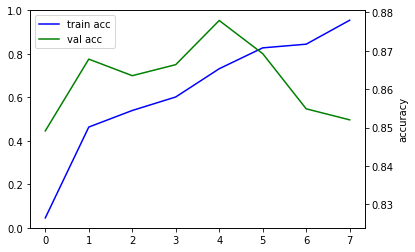

In [63]:
model = cf.train(docs,
                 checkpoint_path='./model/200218',
                 epochs=8,
                )
cf.showHistory()